In [1]:
import os
import time
import torch
import subprocess as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from torch.utils.data import Dataset, DataLoader, random_split

%matplotlib inline

In [2]:
base_path = sp.getoutput('git rev-parse --show-toplevel')
os.chdir(base_path)

from src import embed, pred_models, model_helpers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aupab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Preparation

In [3]:
# Load data
# set folder path
folder_path = "data/"

# get list of files in folder
file_list = os.listdir(folder_path)

# create empty list to hold dataframes
df_list = []

# loop through files in folder
for file in file_list:
    # check if file is a CSV
    if file.endswith('.csv'):
        # read CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file))
        # append dataframe to list
        df_list.append(df)

# concatenate all dataframes in list into a single dataframe
combined_df = pd.concat(df_list, axis=0, ignore_index=True)

C:\Users\aupab\AppData\Local\Temp/ipykernel_21228/4266264643.py:16: DtypeWarning: Columns (60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file))
C:\Users\aupab\AppData\Local\Temp/ipykernel_21228/4266264643.py:16: DtypeWarning: Columns (60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file))
C:\Users\aupab\AppData\Local\Temp/ipykernel_21228/4266264643.py:16: DtypeWarning: Columns (60,62,64,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file))
C:\Users\aupab\AppData\Local\Temp/ipykernel_21228/4266264643.py:16: DtypeWarning: Columns (17,60,62,64,66,68,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file))
C:\Users\aupab\AppData\Local\Temp/ipykernel_21228/4266264643.py:16: DtypeWarning

In [4]:
#try with justice
df = combined_df
df = pd.merge(df, df[['id', 'speaker_type', 'side']], left_on='reply_to', right_on='id', how='left').drop(['id_y'], axis=1)
df.rename(columns={'id_x': 'id', 'speaker_type_x': 'speaker_type', 'speaker_type_y': 'speaker_type_reply_to', 'side_x': 'side', 'side_y': 'side_reply_to'}, inplace=True)

df = pd.merge(df, df[['id', 'speaker_type', 'side']], left_on='addressing', right_on='id', how='left').drop(['id_y'], axis=1)
df.rename(columns={'id_x': 'id', 'speaker_type_x': 'speaker_type', 'speaker_type_y': 'speaker_type_addressing', 'side_x': 'side', 'side_y': 'side_addressing'}, inplace=True)

df['to_same_speaker'] = df['speaker_type_reply_to'] == df['speaker_type_addressing']
#If one is NaN Leave as True - we can still use it. 
df['to_same_speaker'] = df.apply(lambda x: True if pd.isna(x['speaker_type_reply_to']) or pd.isna(x['speaker_type_addressing']) else x['to_same_speaker'], axis=1)

df['to_same_side'] = df['side_reply_to'] == df['side_addressing']
#If one is NaN Leave as True - we can still use it. 
df['to_same_side'] = df.apply(lambda x: True if pd.isna(x['side_reply_to']) or pd.isna(x['side_addressing']) else x['to_same_side'], axis=1)

In [5]:
df['to_same_speaker'] = df['speaker_type_reply_to'] == df['speaker_type_addressing']
#If one is NaN Leave as True - we can still use it. 
df['to_same_speaker'] = df.apply(lambda x: True if pd.isna(x['speaker_type_reply_to']) or pd.isna(x['speaker_type_addressing']) else x['to_same_speaker'], axis=1)

In [6]:
df['to_same_side'] = df['side_reply_to'] == df['side_addressing']
#If one is NaN Leave as True - we can still use it. 
df['to_same_side'] = df.apply(lambda x: True if pd.isna(x['side_reply_to']) or pd.isna(x['side_addressing']) else x['to_same_side'], axis=1)

In [7]:
#model justice to petitioner
df = df[(df['speaker_type'] == 'J') & (df['side_addressing'] == 1) & (df['to_same_side'] == True)]

In [9]:
# Have to do by utterance as grouping by case_id gives too few examples to learn from
df = df[['text', 'win_side', 'case_id']]
df.head()

,text,win_side,case_id
210,"Number 61, David S. Alberts, Appellant, versus...",0.0,1956_61
212,You may proceed.,0.0,1956_61
218,Was this before a jury?,0.0,1956_61
222,Is that the -- it may not be material from wha...,0.0,1956_61
224,"Well, but again --",0.0,1956_61


In [10]:
# TO DISCUSS
df.dropna(subset=['win_side'], inplace=True)
df = df[df.win_side != 2]

In [11]:
# Split the dataset into training and testing sets
#train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

# Assuming you already have a dataframe `df` with a 'case_id' column

# Get unique case_ids
unique_case_ids = df['case_id'].unique()

# Split the unique case_ids into training and testing sets
train_case_ids, test_case_ids = train_test_split(unique_case_ids, test_size=0.2, random_state=123)

# Filter the original dataframe to create the train and test dataframes using the train and test case_ids
train_df = df[df['case_id'].isin(train_case_ids)]
test_df = df[df['case_id'].isin(test_case_ids)]


In [24]:
display(train_case_ids.shape)
display(test_case_ids.shape)

(1153,)

(289,)

### BoW Embedding

In [13]:
# Bag of Words
vocab = embed.get_vocab(train_df, min_freq=10)
vocab_size = len(vocab)
vocab_size

6446

In [14]:
test_df['win_side'].value_counts(normalize=True)

1.0    0.61129
0.0    0.38871
Name: win_side, dtype: float64

### Create training, validation, and testing dataloaders

In [15]:
BATCH_SIZE = 64

train_df = train_df[['text', 'win_side']] # Remove case ID for training
train_valid_data = list(train_df.values)
num_train = int(len(train_valid_data) * 0.95)
num_valid = len(train_valid_data) - num_train
train_data, valid_data = random_split(
    train_valid_data, [num_train, num_valid])
test_data = list(test_df[['text', 'win_side']].values)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=lambda batch: embed.collate_into_bow(batch, vocab)) # pass vocab to collate function
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=lambda batch: embed.collate_into_bow(batch, vocab))
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=lambda batch: embed.collate_into_bow(batch, vocab))

### Training

In [16]:
# BoW NN Classifier
hidden_dim = 300
model = pred_models.BoWNNClassifier(vocab_size=vocab_size, hidden_dim=hidden_dim, output_dim=1)

C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.670.
At iteration 400 the train loss is 0.649.
At iteration 600 the train loss is 0.677.
At iteration 800 the train loss is 0.685.
At iteration 1000 the train loss is 0.721.
After epoch 1 the validation loss is 0.649.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.549.
At iteration 400 the train loss is 0.633.
At iteration 600 the train loss is 0.701.
At iteration 800 the train loss is 0.640.
At iteration 1000 the train loss is 0.590.
After epoch 2 the validation loss is 0.650.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.485.
At iteration 400 the train loss is 0.593.
At iteration 600 the train loss is 0.606.
At iteration 800 the train loss is 0.589.
At iteration 1000 the train loss is 0.526.
After epoch 3 the validation loss is 0.671.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.596.
At iteration 400 the train loss is 0.526.
At iteration 600 the train loss is 0.473.
At iteration 800 the train loss is 0.437.
At iteration 1000 the train loss is 0.570.
After epoch 4 the validation loss is 0.700.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.478.
At iteration 400 the train loss is 0.497.
At iteration 600 the train loss is 0.614.
At iteration 800 the train loss is 0.449.
At iteration 1000 the train loss is 0.481.
After epoch 5 the validation loss is 0.755.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.472.
At iteration 400 the train loss is 0.434.
At iteration 600 the train loss is 0.465.
At iteration 800 the train loss is 0.360.
At iteration 1000 the train loss is 0.599.
After epoch 6 the validation loss is 0.811.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.299.
At iteration 400 the train loss is 0.437.
At iteration 600 the train loss is 0.397.
At iteration 800 the train loss is 0.434.
At iteration 1000 the train loss is 0.423.
After epoch 7 the validation loss is 0.907.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.224.
At iteration 400 the train loss is 0.299.
At iteration 600 the train loss is 0.256.
At iteration 800 the train loss is 0.324.
At iteration 1000 the train loss is 0.340.
After epoch 8 the validation loss is 1.004.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.160.
At iteration 400 the train loss is 0.286.
At iteration 600 the train loss is 0.180.
At iteration 800 the train loss is 0.249.
At iteration 1000 the train loss is 0.339.
After epoch 9 the validation loss is 1.166.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.129.
At iteration 400 the train loss is 0.213.
At iteration 600 the train loss is 0.222.
At iteration 800 the train loss is 0.194.
At iteration 1000 the train loss is 0.165.
After epoch 10 the validation loss is 1.270.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.145.
At iteration 400 the train loss is 0.183.
At iteration 600 the train loss is 0.165.
At iteration 800 the train loss is 0.298.
At iteration 1000 the train loss is 0.242.
After epoch 11 the validation loss is 1.411.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.087.
At iteration 400 the train loss is 0.104.
At iteration 600 the train loss is 0.217.
At iteration 800 the train loss is 0.167.
At iteration 1000 the train loss is 0.259.
After epoch 12 the validation loss is 1.543.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.109.
At iteration 400 the train loss is 0.185.
At iteration 600 the train loss is 0.080.
At iteration 800 the train loss is 0.273.
At iteration 1000 the train loss is 0.200.
After epoch 13 the validation loss is 1.630.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.236.
At iteration 400 the train loss is 0.095.
At iteration 600 the train loss is 0.213.
At iteration 800 the train loss is 0.178.
At iteration 1000 the train loss is 0.099.
After epoch 14 the validation loss is 1.755.


C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the train loss is 0.150.
At iteration 400 the train loss is 0.184.
At iteration 600 the train loss is 0.114.
At iteration 800 the train loss is 0.121.
At iteration 1000 the train loss is 0.164.
After epoch 15 the validation loss is 1.911.


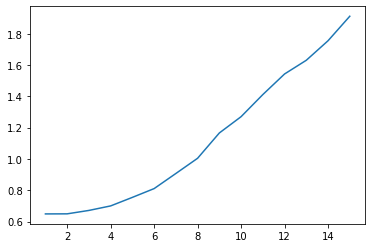

In [17]:
import numpy as np
EPOCHS = 15
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_model = None
best_val_loss = float('inf')
val_losses = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model_helpers.train_an_epoch(model, train_dataloader, optimizer, loss_function)
    val_y_true, val_y_pred = model_helpers.make_predictions(model, valid_dataloader)
    val_loss = log_loss(val_y_true.astype(np.float64), val_y_pred.astype(np.float64))
    if val_loss < best_val_loss:
        best_model = type(model)(model.vocab_size, model.hidden_dim, model.output_dim) # get a new instance
        best_model.load_state_dict(model.state_dict())
        best_val_loss = val_loss
    val_losses.append(val_loss)
    time_taken = time.time() - epoch_start_time
    print(f'After epoch {epoch} the validation loss is {val_loss:.3f}.')
    
plt.plot(range(1, EPOCHS+1), val_losses)

C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Best Threshold=0.816811, G-Mean=0.614


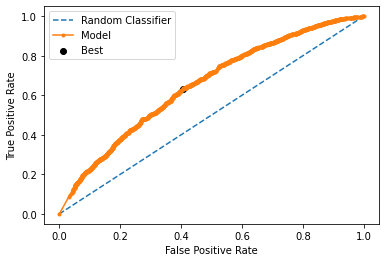

In [18]:
# Get validation predictions to select best threshold
val_labels, val_probs = model_helpers.make_predictions(model, valid_dataloader)
# Get best threshold from validation data
threshold = model_helpers.select_threshold(val_labels, val_probs)

In [19]:
test_results_df = model_helpers.get_test_results_df(best_model, test_dataloader, test_df[['case_id', 'win_side']])
test_results_df.head()

C:\Users\aupab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


,case_id,win_side,labels,prob
2551,1956_204,0.0,0.0,0.609407
2553,1956_204,0.0,0.0,0.618066
2555,1956_204,0.0,0.0,0.596117
2557,1956_204,0.0,0.0,0.519192
2559,1956_204,0.0,0.0,0.642692


### Exploring results w confusion matrix

In [20]:
# Results dataframe per utterance
per_utterance_df = (test_results_df
                    .assign(pred=lambda x: x['prob']
                    .apply(lambda y: 1 if y > threshold else 0)))

# petitioner 1, respondent 0
display(per_utterance_df.pred.value_counts())
per_utterance_df.win_side.value_counts()

0    15601
1      254
Name: pred, dtype: int64

1.0    9692
0.0    6163
Name: win_side, dtype: int64

In [21]:
# Results dataframe per case
per_case_df = (test_results_df
                .groupby('case_id')
                .mean()
                .assign(pred=lambda x: x['prob']
                .apply(lambda y: 1 if y > threshold else 0)))

# petitioner 1, respondent 0
display(per_case_df.pred.value_counts())
per_case_df.win_side.value_counts()

0    289
Name: pred, dtype: int64

1.0    179
0.0    110
Name: win_side, dtype: int64

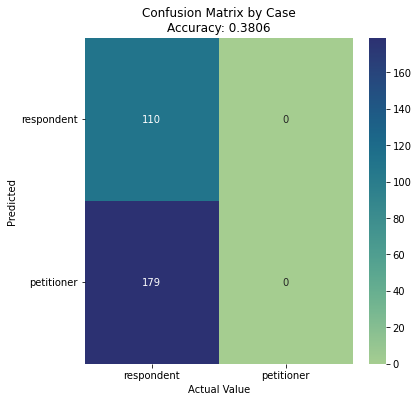

In [22]:
# Confusion matrix by case
model_helpers.results_heatmap(per_case_df['win_side'],
                per_case_df['pred'],
                'Confusion Matrix by Case',
                target_names = ['respondent', 'petitioner'])

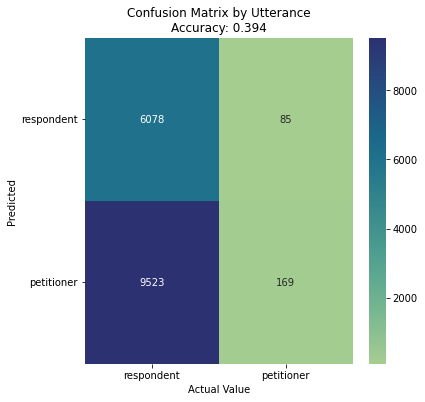

In [23]:
# Confusion matrix by utterance
model_helpers.results_heatmap(per_utterance_df['win_side'],
                per_utterance_df['pred'],
                'Confusion Matrix by Utterance',
                target_names = ['respondent', 'petitioner'])